# 프로젝트 확장

## 확장 프로젝트 1: 시기별(10년 단위) 장르별 Rates, Gross, Votes 평점 변화 분석

#### 한글 폰트 깨짐 방지

In [1]:
# ✅ Colab에서 한글 폰트 설정 + 경고 억제 (재시작 없이)
import os, glob, logging, warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib.font_manager import fontManager

# 1) 폰트 설치 (Nanum → 실패 시 Noto Sans CJK로 대체)
try:
    # 조용히 설치
    import subprocess, sys
    subprocess.run(["apt-get", "install", "-y", "-qq", "fonts-nanum"], check=True)
except Exception as e:
    print("Nanum 설치 경고:", e)
    subprocess.run(["apt-get", "install", "-y", "-qq", "fonts-noto-cjk"], check=False)

# 2) 설치된 TTF 경로 수집
candidates = []
candidates += glob.glob("/usr/share/fonts/truetype/nanum/*.ttf")
candidates += glob.glob("/usr/share/fonts/opentype/noto/*.otf")
candidates += glob.glob("/usr/share/fonts/truetype/noto/*.ttf")

# 3) matplotlib에 수동 등록
for fp in candidates:
    try:
        fontManager.addfont(fp)
    except Exception:
        pass

# 4) 선호 폰트 우선순위 지정
preferred_families = [
    "NanumGothic", "Nanum Gothic",
    "Noto Sans CJK KR", "Noto Sans CJK", "Noto Sans"
]

# 실제로 등록된 폰트 패밀리 확인 후 선택
available = set(f.name for f in fm.fontManager.ttflist)
chosen = None
for fam in preferred_families:
    if fam in available:
        chosen = fam
        break

# 5) rcParams 적용 + 마이너스 깨짐 방지
if chosen:
    mpl.rcParams["font.family"] = chosen
else:
    # 최후의 수단: DejaVu Sans 사용(한글 일부 미표시 가능)
    mpl.rcParams["font.family"] = "DejaVu Sans"

mpl.rcParams["axes.unicode_minus"] = False

# 6) font_manager 경고/로깅 억제
warnings.filterwarnings("ignore", module="matplotlib.font_manager")
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

print("✅ 사용 폰트:", mpl.rcParams["font.family"])


✅ 사용 폰트: ['NanumGothic']


#### 데이터 불러오기

In [2]:
import os
import pandas as pd
import numpy as np
import kagglehub
# Download latest version
path = kagglehub.dataset_download("omarhanyy/imdb-top-1000")
file_path = os.path.join(path, "IMDB top 1000.csv")
print(file_path)

100%|██████████| 143k/143k [00:00<00:00, 40.9MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/omarhanyy/imdb-top-1000/versions/1/IMDB top 1000.csv


#### 시각화

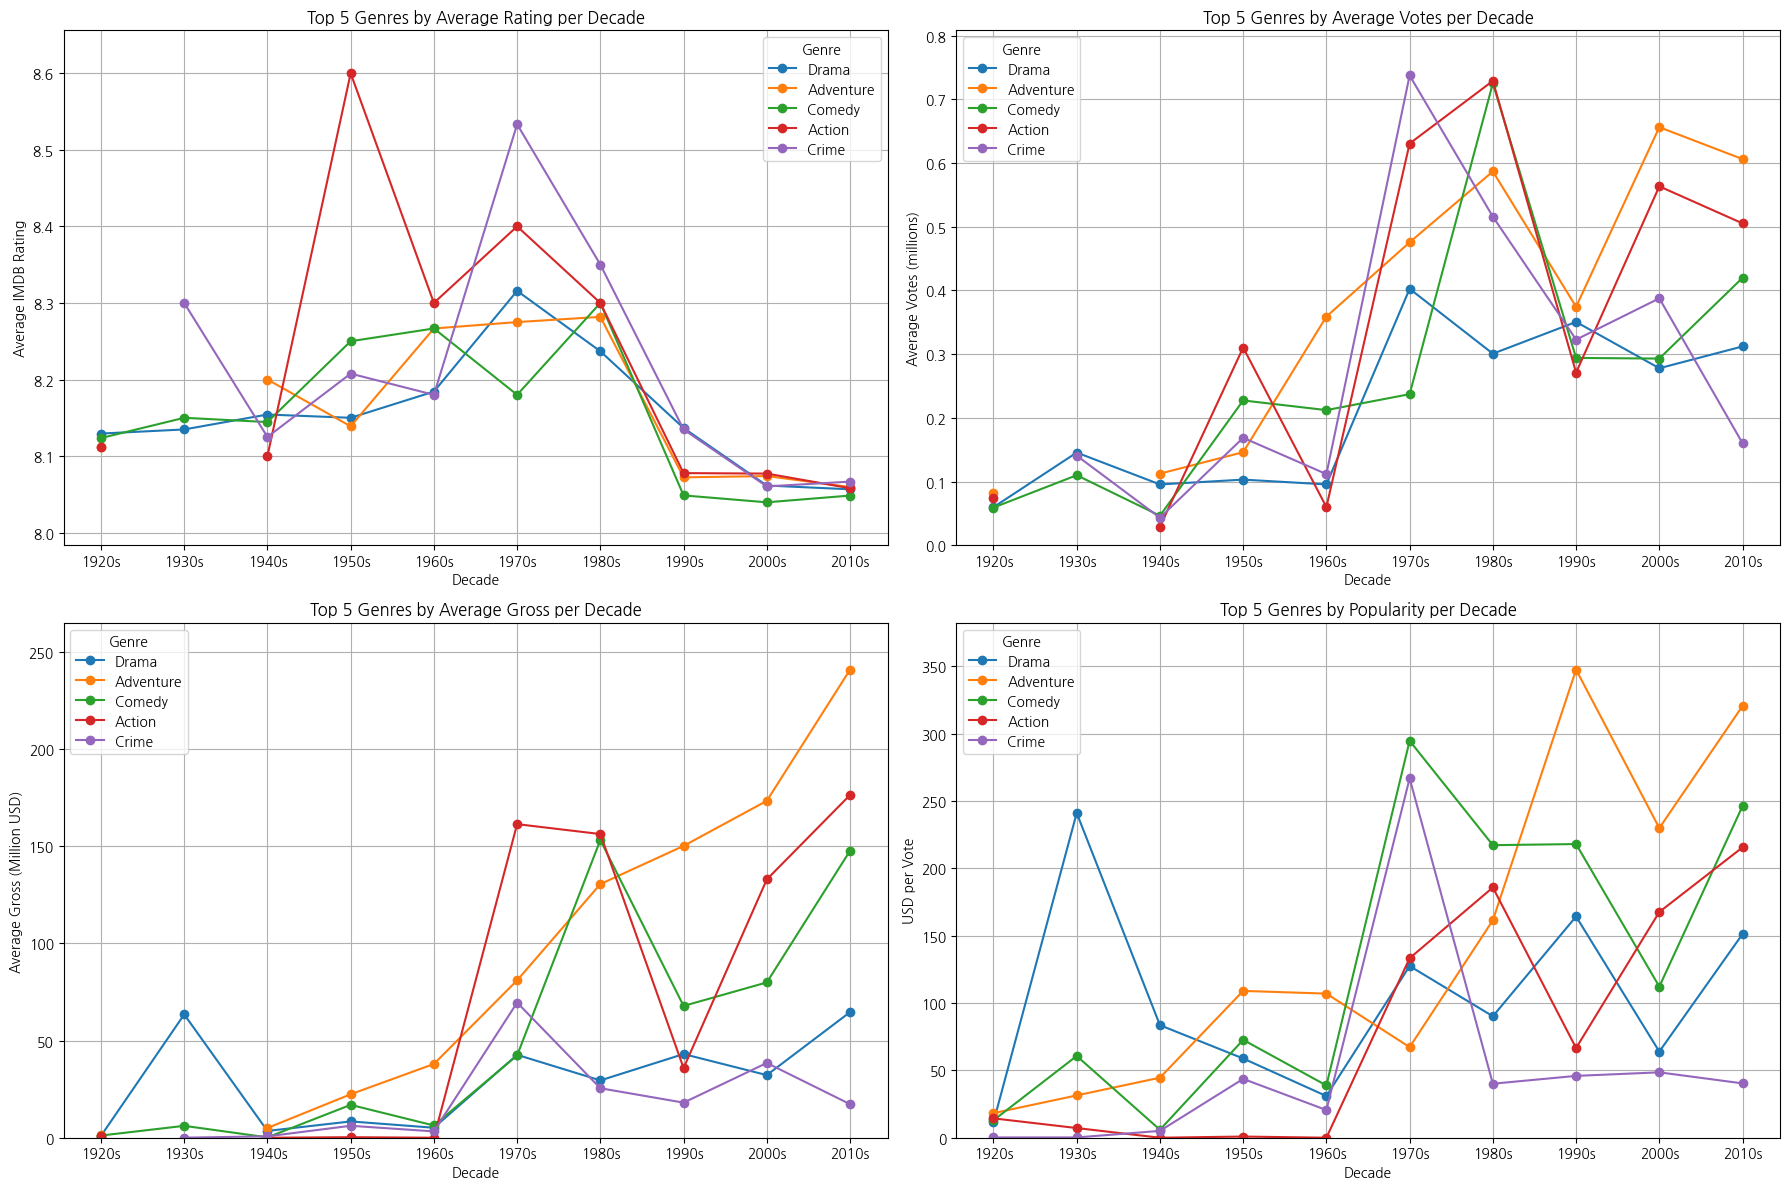

In [3]:
# =========================
# 1) 공통 전처리 함수
# =========================
def build_base_df(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)

    # 필수 컬럼 결측 제거 및 타입 정리
    df = df.dropna(subset=["Title", "Genre", "Rate"]).copy()
    df["Rate"] = df["Rate"].astype(float)

    # Title에서 (YYYY) 추출 → Released_Year
    df["Released_Year"] = (
        df["Title"].str.extract(r"\((\d{4})\)", expand=False).astype(int)
    )

    # Info 결측 대체
    df["Info"] = df["Info"].fillna("Votes:0|Gross:$0M")

    # Votes 추출
    votes_col = df["Info"].str.split("|").str[0].str.replace("Votes:", "", regex=False)
    df["Votes"] = (
        votes_col.str.replace(",", "", regex=False)
                 .str.strip()
                 .astype(float)
    )

    # Gross 추출(단위: 백만 달러, M 제거)
    gross_col = df["Info"].str.split("|").str[1]
    df["Gross"] = (
        gross_col.str.replace("Gross:", "", regex=False)
                 .str.replace("$", "", regex=False)
                 .str.replace("M", "", regex=False)
                 .str.strip()
    )
    df["Gross"] = pd.to_numeric(df["Gross"], errors="coerce").fillna(0.0)  # Million USD

    # 장르 explode
    df["Genre"] = df["Genre"].str.split(",")
    df = df.explode("Genre")
    df["Genre"] = df["Genre"].str.strip()

    # 연대
    df["Decade"] = (df["Released_Year"] // 10) * 10

    # 샘플수 적은 연대 제거(20편 미만 제외)
    decade_counts = df["Decade"].value_counts().sort_index()
    valid_decades = decade_counts[decade_counts >= 20].index
    df = df[df["Decade"].isin(valid_decades)].copy()

    return df


# =========================
# 2) 피벗 + Top5 장르 선택
# =========================
def make_pivot(df: pd.DataFrame, value_col: str) -> pd.DataFrame:
    """행=Decade, 열=Genre, 값=value_col 평균"""
    g = df.groupby(["Decade", "Genre"], as_index=False)[value_col].mean()
    pv = g.pivot(index="Decade", columns="Genre", values=value_col)
    pv = pv.sort_index()  # 연대 오름차순 보장
    return pv


def pick_top5_genres(df: pd.DataFrame) -> pd.Index:
    """영화 개수 기준 상위 5개 장르"""
    return df["Genre"].value_counts().head(5).index


# =========================
# 3) 단일 축(서브플롯용) 라인 플롯
# =========================
def plot_single_axis(
    pivot_df: pd.DataFrame,
    top_genres: pd.Index,
    ax,
    title: str,
    ylabel: str,
    interpolate_missing: bool = False
):
    # 상위 장르만 선택 (없는 열은 드랍)
    cols = [g for g in top_genres if g in pivot_df.columns]
    data = pivot_df[cols].copy()

    # X축(연대) 범위
    decades = np.arange(data.index.min(), data.index.max() + 10, 10)

    if interpolate_missing:
        data = (
            data.reindex(decades)
                .astype(float)
                .interpolate(method="linear", axis=0)
                .ffill()
                .bfill()
        )
    else:
        data = data.reindex(decades)

    data.plot(ax=ax, marker="o")

    ax.set_title(title)
    ax.set_xlabel("Decade")
    ax.set_ylabel(ylabel)

    # X tick: "1970s" 형식
    ax.set_xticks(decades)
    ax.set_xticklabels([f"{d}s" for d in decades])

    # Y 범위 여유
    ymin = np.nanmin(data.values)
    ymax = np.nanmax(data.values)
    if np.isfinite(ymin) and np.isfinite(ymax):
        pad = (ymax - ymin) * 0.1 if ymax > ymin else (ymax or 1) * 0.1
        ax.set_ylim(max(0, ymin - pad), ymax + pad)

    ax.grid(True)
    ax.legend(title="Genre", loc="best")


# =========================
# 4) 2x2 Subplot 묶음 플로팅
# =========================
def plot_top5_subplots(df_base: pd.DataFrame, top5: pd.Index):
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # 2x2 서브플롯
    axes = axes.flatten()

    # (a) 평점
    pv_rate = make_pivot(df_base, "Rate")
    plot_single_axis(pv_rate, top5, axes[0],
                     title="Top 5 Genres by Average Rating per Decade",
                     ylabel="Average IMDB Rating")

    # (b) 투표수(백만 단위)
    pv_votes = make_pivot(df_base, "Votes") / 1_000_000
    plot_single_axis(pv_votes, top5, axes[1],
                     title="Top 5 Genres by Average Votes per Decade",
                     ylabel="Average Votes (millions)")

    # (c) 흥행수익(Million USD)
    pv_gross = make_pivot(df_base, "Gross")
    plot_single_axis(pv_gross, top5, axes[2],
                     title="Top 5 Genres by Average Gross per Decade",
                     ylabel="Average Gross (Million USD)")

    # (d) 인기 지표 (USD per Vote)
    pop = (df_base["Gross"] * 1_000_000) / df_base["Votes"].replace(0, np.nan)
    df_tmp = df_base.assign(Popularity=pop)
    pv_pop = make_pivot(df_tmp, "Popularity")
    plot_single_axis(pv_pop, top5, axes[3],
                     title="Top 5 Genres by Popularity per Decade",
                     ylabel="USD per Vote",
                     interpolate_missing=True)

    plt.tight_layout()
    plt.show()


# =========================
# 5) 실행
# =========================
# 예: file_path = "/path/to/imdb_top_1000.csv"
df_base = build_base_df(file_path)
top5 = pick_top5_genres(df_base)
plot_top5_subplots(df_base, top5)

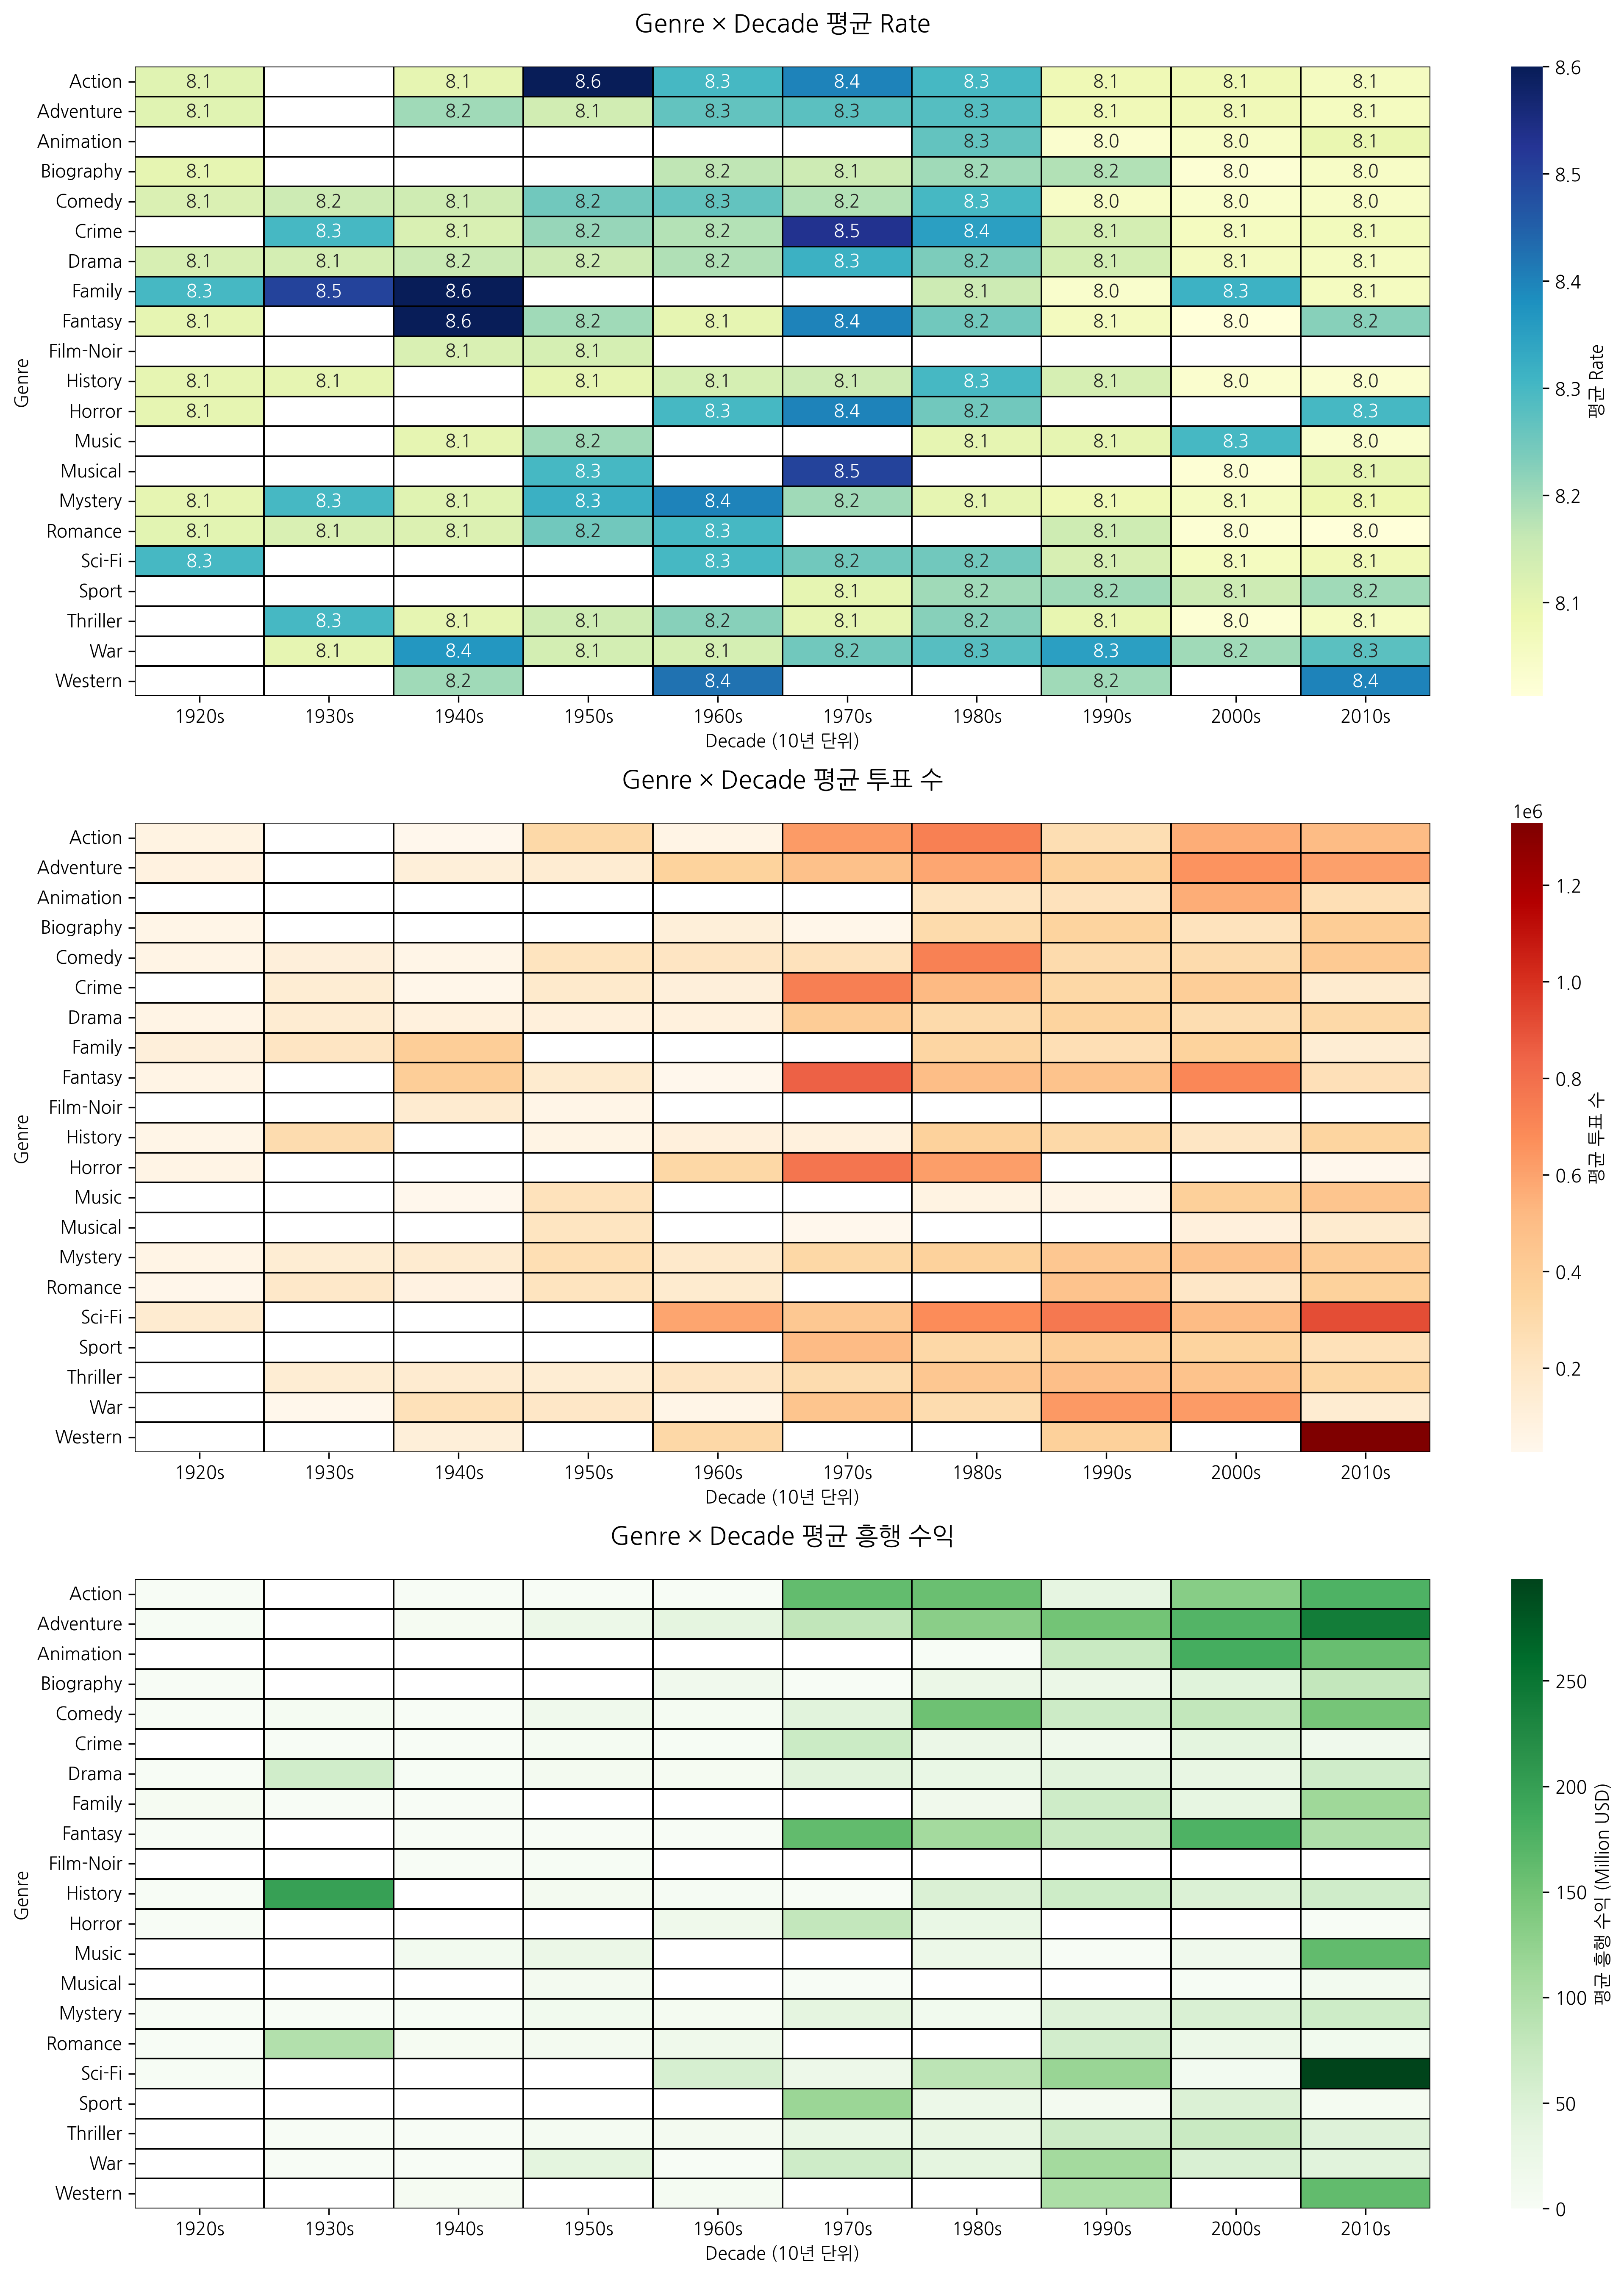

In [5]:
# =========================
# 히트맵: Genre × Decade 평균 (Rate / Vote / Gross)
# =========================
import seaborn as sns
import numpy as np
import pandas as pd
import warnings

# 불필요한 경고 숨기기
warnings.filterwarnings("ignore")

# 1) 연대×장르별 평균 집계
result = (
    df_base.groupby(["Decade", "Genre"], as_index=False)
           .agg(Avg_Rate=("Rate", "mean"),
                Avg_Vote=("Votes", "mean"),
                Avg_Gross=("Gross", "mean"))  # Gross는 이미 'Million USD'
)

# 2) 2020년대 제외
result_filtered = result[result["Decade"] < 2020].copy()

# 3) 피벗 (행=Genre, 열=Decade)
pivot_rate  = result_filtered.pivot(index="Genre", columns="Decade", values="Avg_Rate")
pivot_vote  = result_filtered.pivot(index="Genre", columns="Decade", values="Avg_Vote")
pivot_gross = result_filtered.pivot(index="Genre", columns="Decade", values="Avg_Gross")

# 3-1) 열(Decade) 정렬 보장
pivot_rate  = pivot_rate.reindex(sorted(pivot_rate.columns), axis=1)
pivot_vote  = pivot_vote.reindex(sorted(pivot_vote.columns), axis=1)
pivot_gross = pivot_gross.reindex(sorted(pivot_gross.columns), axis=1)

# 3-2) x축 라벨을 '1950s' 형식으로 만들 준비
def decade_labels(cols):
    return [f"{int(c)}s" for c in cols]

# 4) 그리기
fig, axes = plt.subplots(3, 1, figsize=(14, 18), dpi=300)

# (a) 평균 Rate 히트맵
sns.heatmap(pivot_rate, annot=True, fmt=".1f", cmap="YlGnBu",
            cbar_kws={'label': '평균 Rate'},
            linewidths=0.5, linecolor="black", ax=axes[0])
axes[0].set_title("Genre × Decade 평균 Rate", fontsize=14, pad=20)
axes[0].set_xlabel("Decade (10년 단위)")
axes[0].set_ylabel("Genre")
axes[0].set_xticklabels(decade_labels(pivot_rate.columns), rotation=0)

# (b) 평균 Vote 히트맵
sns.heatmap(pivot_vote, annot=False, cmap="OrRd",
            cbar_kws={'label': '평균 투표 수'},
            linewidths=0.5, linecolor="black", ax=axes[1])
axes[1].set_title("Genre × Decade 평균 투표 수", fontsize=14, pad=20)
axes[1].set_xlabel("Decade (10년 단위)")
axes[1].set_ylabel("Genre")
axes[1].set_xticklabels(decade_labels(pivot_vote.columns), rotation=0)

# (c) 평균 Gross 히트맵
sns.heatmap(pivot_gross, annot=False, cmap="Greens",
            cbar_kws={'label': '평균 흥행 수익 (Million USD)'},
            linewidths=0.5, linecolor="black", ax=axes[2])
axes[2].set_title("Genre × Decade 평균 흥행 수익", fontsize=14, pad=20)
axes[2].set_xlabel("Decade (10년 단위)")
axes[2].set_ylabel("Genre")
axes[2].set_xticklabels(decade_labels(pivot_gross.columns), rotation=0)

plt.tight_layout()
plt.show()